# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

+ 之前记笔记的时候想错了，以为svm模型有自己的函数形式，但其实就是线性分类器而已，时隔太久再看英文课程有点没跟上思路了，形式就是f(x) = W.T \* x + b（bias可以合并到Wx内），另外注意这里的W.T \* x是指理论资料中向量默认为列向量的情况，但其实numpy里读入数据时是默认行向量的，所以后面计算时是X.dot(W)，X即num_sample个x.T vector。
+ 他首先讲了线性分类器，然后说到svm和softmax两种损失函数，当时还以为跳过了讲模型函数形式的部分直接重点讲Loss Function，其实是只需要讲这部分，笔记需要重新看（笔记真的写得很好）。
+ 噢，我说的svm模型自己的函数形式指的就是cs231n讲到的score function评分函数。

相关文件——
data_utils.py
linear_classifier.py
linear_svm.py


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


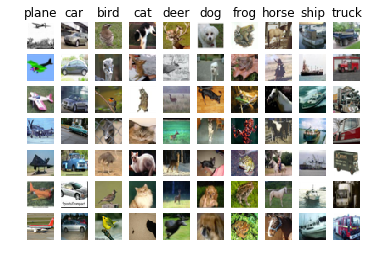

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

这些固定的写法就不看了，自己写两遍总能再熟悉起来的，下面开始跟knn不一样的部分。

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
# dev集作为训练集的子集，可以代码运行得更快，跟knn里面二次采样减小数据集以便快速调试代码是一个意思吧？
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


这里也和kNN的做法不同，通过减去均值然后除以方差（或标准差）来进行标准化。
https://www.zhihu.com/question/49096923/answer/518032757 答案里有很多种解释，对于理解帮助很大，cs231n之后的章节似乎还会讲到。

[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


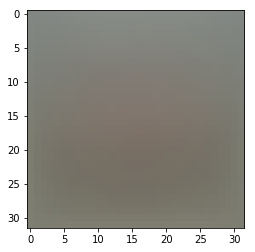

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# 本来线性模型是f(x) = W * x + b (默认列向量的话W其实该是W.T)，但可以利用技巧将bias偏差和weight权重合并，这样就只剩下一个需要学习的参数W，
# 方法是，假设x是n维向量，f(x)是c维向量，则W是c x n矩阵，b是c维向量，
# 如果想将W和b合并，就直接将b加入W作为最后一列，W变为c x (n + 1)维，而x的第n + 1行添加一行1，效果等同于加上c维的向量b。
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [7]:
# import numpy
# print(numpy.zeros(3, 4)) # 这种写法是错的，传进去的应该是个元组，这样参数数量就不会被限制了
print(np.zeros((3, 4)))

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 # 初始化一个随机的W，所以每次的loss都不一样

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.071381


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you
# 用数值分析的方法计算跟微分梯度分析方法相差很小，得学一下这个函数的写法

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 10.732049 analytic: 10.732049, relative error: 4.476442e-11
numerical: 6.183424 analytic: 6.183424, relative error: 3.377884e-11
numerical: 10.589954 analytic: 10.589954, relative error: 1.453491e-11
numerical: -22.891791 analytic: -22.891791, relative error: 1.044399e-11
numerical: 1.591329 analytic: 1.591329, relative error: 2.229255e-10
numerical: 17.380844 analytic: 17.380844, relative error: 1.133502e-11
numerical: 7.958383 analytic: 7.958383, relative error: 2.527973e-12
numerical: -9.184594 analytic: -9.184594, relative error: 2.261740e-11
numerical: -5.495309 analytic: -5.495309, relative error: 1.154874e-11
numerical: 2.525106 analytic: 2.525106, relative error: 8.190243e-12
numerical: 2.311896 analytic: 2.311896, relative error: 8.881914e-11
numerical: 17.773805 analytic: 17.773805, relative error: 3.538061e-12
numerical: -17.664683 analytic: -17.664683, relative error: 5.841719e-12
numerical: -7.439423 analytic: -7.439423, relative error: 5.301618e-11
numerical: 2

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$

可能有某个维度特征的梯度数值解和解析解差异较大，也就是问题中说的梯度检查不匹配，我认为有三种可能：
+ 第一种是手动微分需要人工求梯度计算导数，如果公式计算错误那么结果会出错，这也正是cs231n课程包括官方笔记中提到的，求解析解容易出错，并需要数值解来gradcheck的原因；
+ 第二种是比如求函数x^2的梯度公式是2x，在x=0时梯度应该为0，数值分析方法将h设为0.0001，结果则为1e-6，其他函数此处斜率更大的函数比如1000x^2可能相差更多，在这些情况下也会出现较大discrepancy；
+ 第三种是在某些点处，有些function可能不可微，无法求导，比如\|x\|，在x=0处不可微也可能导致这样的情况。

但总的来说这些差异影响不大。

学习经验：在推导/写代码之前，把矩阵或者思路有条理地画出来，想>>写。

另外，以后就设特征数为n，样本容量是m，分类问题的类别数是c，给样本的c个类别打分是s，固定了。

In [10]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.071381e+00 computed in 0.109138s
Vectorized loss: 9.071381e+00 computed in 0.082796s
difference: -0.000000


In [11]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro') # 这个函数到底是干嘛用的？
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.109793s
Vectorized loss and gradient: computed in 0.001998s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [12]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
# 实现SGD随机梯度下降，这里说的SGD包括以后看到的通常是指mini-batch MGD，stochastic SGD严格来说是batch=1的在线梯度下降情况
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 403.369754
iteration 100 / 1500: loss 240.271024
iteration 200 / 1500: loss 146.570581
iteration 300 / 1500: loss 90.784217
iteration 400 / 1500: loss 56.374023
iteration 500 / 1500: loss 35.570424
iteration 600 / 1500: loss 23.370799
iteration 700 / 1500: loss 16.400012
iteration 800 / 1500: loss 11.409185
iteration 900 / 1500: loss 8.555456
iteration 1000 / 1500: loss 7.293547
iteration 1100 / 1500: loss 6.134966
iteration 1200 / 1500: loss 6.039237
iteration 1300 / 1500: loss 5.661906
iteration 1400 / 1500: loss 4.987299
That took 4.728205s


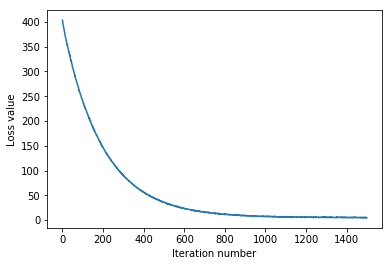

In [13]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
# 一个很有效的调试策略是将每个iter这个batch计算出的loss画出来观察曲线
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [14]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
# 实现模型的预测函数并且分别在训练集和验证集上评估性能，这里的验证集是来确定哪个超参的？学习率和正则项参数吗？待会看下面一个cell
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.382388
validation accuracy: 0.392000


In [15]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.
# 噢果然是学α和λ，要我尝试不同的正则项系数（这里用的叫正则化强度）和学习率

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.(tune, adjust for (better) functioning, En2En Translate)#
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7] # 学习率Stanford给的范围是0.00000001到0.000005，这两个超参都要根据下面的图自己调整数量级的
# 按照下面这种写法一个[]只能写一个这种形式的列表
regularization_strengths = [(1 + i * 0.1) * 1e4 for i in range(-3, 3)] + [(2 + i * 0.1) * 1e4 for i in range(-3, 3)] # 正则化强度给的范围是25000到50000，这两个超参的尺度跟我印象里的好像不太一样...

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# 要做的任务是，通过尝试不同的超参数确定准确率最高的那一组，那么得让一个不变，去尝试另一个，双层循环好像就够了，这段跟求损失/梯度和SGD一样，是核心代码
for lr in learning_rates: # lr和rs越多，num_iters越大，batch_size越大，这段代码就跑得越慢
    for rs in regularization_strengths:
        svm = LinearSVM()
        loss_history = svm.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=3000, batch_size=200, verbose=False) # 写到这突然发现一个vscode快捷键，ctrl -/+才是缩放，设置了num_iters为100，我看lightaime这里设置了3000，且上面的lr和rs范围也修改过，噢，这才发现上面SGD的时候也被设置成了1500而不是默认值，这里要自己调好超参才行，是个三维的图像，颜色表示准确率，横纵轴分别是log降低数量级处理后的两个超参，svm参考了太多资料，softmax要用到的知识基本都具备了，下一个task独立完成
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.sum(y_train_pred==y_train) / num_training
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.sum(y_val_pred==y_val) / num_validation
        results[(lr, rs)] = (train_accuracy, val_accuracy)

        if val_accuracy > best_val:
            best_val = val_accuracy
            # best_svm = (lr, rs)
            best_svm = svm # wtf，对啊，这个对象是可以被保存的，我第一反应是保存两个超参，但W也需要被保存啊

# pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 7.000000e+03 train accuracy: 0.398714 val accuracy: 0.396000
lr 1.000000e-07 reg 8.000000e+03 train accuracy: 0.397959 val accuracy: 0.399000
lr 1.000000e-07 reg 9.000000e+03 train accuracy: 0.396939 val accuracy: 0.399000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.390224 val accuracy: 0.386000
lr 1.000000e-07 reg 1.100000e+04 train accuracy: 0.395551 val accuracy: 0.392000
lr 1.000000e-07 reg 1.200000e+04 train accuracy: 0.391082 val accuracy: 0.409000
lr 1.000000e-07 reg 1.700000e+04 train accuracy: 0.387020 val accuracy: 0.386000
lr 1.000000e-07 reg 1.800000e+04 train accuracy: 0.390531 val accuracy: 0.395000
lr 1.000000e-07 reg 1.900000e+04 train accuracy: 0.389204 val accuracy: 0.398000
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.382918 val accuracy: 0.391000
lr 1.000000e-07 reg 2.100000e+04 train accuracy: 0.376388 val accuracy: 0.389000
lr 1.000000e-07 reg 2.200000e+04 train accuracy: 0.380735 val accuracy: 0.374000
lr 2.000000e-07 reg 7.000000

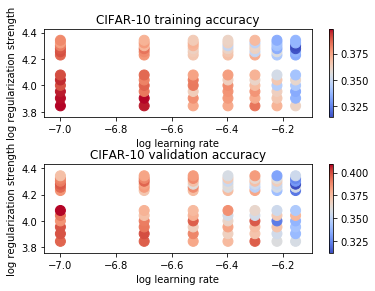

In [16]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [17]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test) # 这里是直接把这个分类器的实例拿来用了，用的是个对象，是个要记住的操作
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.376000


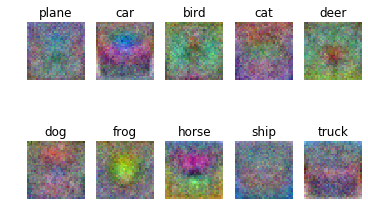

In [18]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$

就像Lecture里面说的，线性分类器包括SVM本质上是一种模板匹配，S=XW这里weights矩阵学到的实际上是匹配各种分类的模板，从上面最终的权重矩阵图中实际上可以看出各个类别的轮廓，c个类别对应的实际上是W中的c列，分别是c个类别的模板，用这个轮廓和测试集中的图片进行匹配，以此作为打分和预测的依据。


这部分写太久了，终于结束，未解决的问题是，
+ 公式没有全部手推，整体的记忆需要做note或者report才能更加清晰牢靠。
+ 直到最后也没搞明白为什么svm梯度公式是，求导之后只剩一个指示函数和X\[i\]了，后来花了三两天搞明白，但||X||F求导还没推出来，大概都搞懂了，之后会整理公式。
+ 数值法和微分法计算分析梯度，两种公式和两个函数都不是独立理解和实现的，需要自己做一遍。

按照knn的jupyter来写，

算法思路：
+ 1, 数据处理，划分的数据集跟knn差不多，但我没用到dev_set；
    + 后来，写softmax的时候，迟钝的我终于发现，在实际做SGD训练模型之前所有的测试debug都用的是X_dev和y_dev两个数据集，怪不得跑得那么快！
+ 2, 训练模型：
    + 2.1, 随机初始化权重矩阵W，这个都是assignment提供的，还没自己实际写过；
    + 2.2, 使用打分函数S=XW给m个样本X根据n个特征分别打出c个类别的得分，根据最高分预测类别；
    + 2.3, 计算Loss和Gradient（维度和W相同）并用数值法进行梯度检查；
    + 2.4, 上面是loops实现，再用vectorized的方法实现一次；
    + 2.5, SGD（更准确地说是MGD）更新梯度。
+ 3, 并用上述步骤确定超参学习率和正则强度，简单来说就是尝试num_alpha * num_lambda次步骤2，分别使用不同的learning_rate和regularization_strength，并记录下最优classifier模型的那个object；
+ 4, 预测test set并计算accuracy；
+ 5, 权重可视化。（非必须）

实现流程：
+ 相比knn其实总的步骤是差不多的，没看懂的也依旧没去弄懂；
+ 但是多了Gradient Descent的Loss曲线，数值方法梯度检查，向量化方法的速度比较和权重可视化；
+ 相比knn只有一个超参k，用交叉验证画了二维图像，svm是两个超参α和λ，用普通的验证集画了伪三维图像手动微调了超参。

所以，我究竟在这个过程中学会了什么？其实直接看assignment即本jupyter开头的那个任务要求就大致知道我可以从中学到什么了，这里更具体地说一下，
+ svm的原理和实现。
+ 相比knn的处理流程，svm内含的则是一个更普遍适用的机器学习算法流程，
    + 分割数据集；
    + 构建模型，
        + 确定模型空间（比如线性的f(x)=wx+b）并随机初始化weights权重；
        + 计算Loss和Gradient，并用梯度下降方法求解这个最优化问题的数值解，求出最终的W；
    + 改变上述模型的超参，确定最优超参；
    + 就用predict validation set的过程中产生的最优模型（记录下那个object即可），而不是重新训练一个出来（当然可以这么做）；
    + 预测，评估。
+ 如何向量化地计算Loss/Gradient/Score，这会让训练过程变得快非常多，但这本身是个很难很巧妙的过程，我只学到了个大概。
+ 可视化Gradient Descent中的Loss并手动调超参。
+ 权重矩阵的可视化，以及很多numpy的新发现的操作等，还没有完全琢磨透，值得进一步实践并学习。

总的来说主要学到了，svm的原理和实现，Loss Fucntion = Data Loss + Regularization的计算和梯度计算，随机梯度下降SGD的思路和实现细节。（之后写report的时候会优化一下这部分学习总结，写得精简且直观些。